In [1]:
from MAUtil import *
from MAInit import *
from MACalc import *
from MAPost import *
import re
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 100)

In [2]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

In [3]:
db = client.adsE_database
collection = db.adsE_collection

### prepare data for prediction ###

In [4]:
dictlis = [#{'element':'Cu', 'face':'100', 'isvalid':'yes', 'unitlength':2},
#            {'element':'Cu', 'face':'111', 'isvalid':'yes', 'unitlength':2},
#            {'element':'Ag', 'face':'100', 'isvalid':'yes', 'unitlength':2},
#            {'element':'Ag', 'face':'111', 'isvalid':'yes', 'unitlength':2},
#            {'element':'Pt', 'face':'100', 'isvalid':'yes', 'unitlength':2},
#            {'element':'Pt', 'face':'111', 'isvalid':'yes', 'unitlength':2},
# #            {'element':'NiGa', 'mirror':'110', 'moved+':'no', 'moved':'no'},
# #            {'element':'CoPt3', 'mirror':'100', 'moved+':'no', 'moved':'no'},
#            {'element':'Pd', 'face':'100', 'isvalid':'yes', 'unitlength':2},           
           {'element':'Pd', 'face':'111'},           
#            {'element':'Au', 'face':'100', 'isvalid':'yes', 'unitlength':2},           
#            {'element':'Au', 'face':'111', 'isvalid':'yes', 'unitlength':2},           
#            {'element':'Al', 'face':'100', 'isvalid':'yes', 'unitlength':2},           
#            {'element':'Al', 'face':'111', 'isvalid':'yes', 'unitlength':2},           
#            {'element':'Ni', 'face':'100', 'isvalid':'yes', 'unitlength':2},           
#            {'element':'Ni', 'face':'111', 'isvalid':'yes', 'unitlength':2},           
          ]

In [5]:
dataset = []
for i in range(len(dictlis)):
    dataset.append(dataset_utilizer(**dictlis[i]))

In [6]:
covset = []
for i in range(len(dataset)):
    covset.append(sorted(list(set(dataset[i].dfpred['coverage']))))
covset

[[0.5, 0.75, 1.0]]

### Predict ####

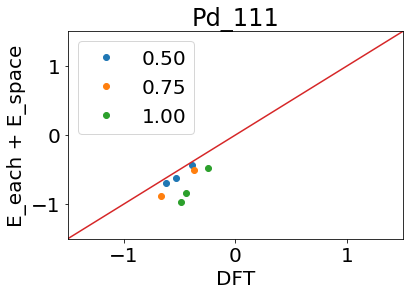

In [7]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20
for i in range(len(dataset)):
    ax = fig.add_subplot(5, 4, i+1)
    xmin = 100
    xmax = -100

    for j in range(len(covset[i])):
        data = dataset[i].dfpred[dataset[i].dfpred['coverage'] == covset[0][0]]
        aveadsE_suratom = np.array(dataset[i].dfpred[dataset[i].dfpred['coverage'] == covset[i][j]]['aveadsE/suratom'])
        E_residue = np.array(dataset[i].dfpred[dataset[i].dfpred['coverage'] == covset[i][j]]['E_residue/suratom'])
        E_prepred = aveadsE_suratom - E_residue
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_prepred, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_each + E_space')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
# plt.savefig('')
# plt.show()

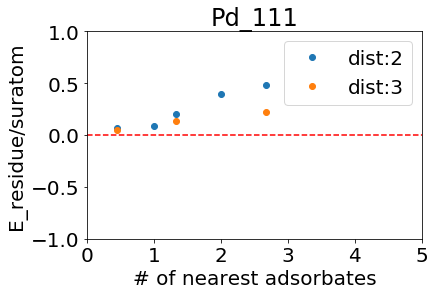

In [22]:
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20

xmin = 0
xmax = 5
for i in range(len(dataset)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.plot(dataset[i].dfpred[dataset[i].dfpred['minimum_distance']==2]['ads_dist2'], dataset[i].dfpred[dataset[i].dfpred['minimum_distance']==2]['E_residue/suratom'], 'o')
    ax.plot(dataset[i].dfpred[dataset[i].dfpred['minimum_distance']==3]['ads_dist3'], dataset[i].dfpred[dataset[i].dfpred['minimum_distance']==3]['E_residue/suratom'], 'o')
    ax.plot([xmin,xmax],[0,0], "red", linestyle='dashed') # normal way
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
    ax.set_xlabel('# of nearest adsorbates')
    ax.set_ylabel('E_residue/suratom')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    plt.legend(['dist:2','dist:3'])
# plt.savefig('')
    plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.show()

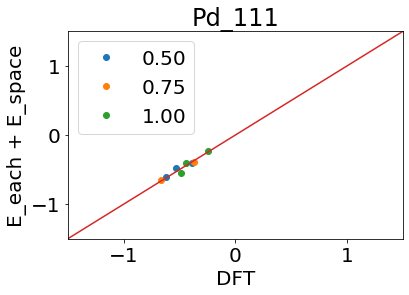

In [26]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20

for i in range(len(dataset)):
    ax = fig.add_subplot(5, 4, i+1)
    xmin = 100
    xmax = -100
    weight2, weight3 = dataset[i].fit_weight_from_specific_element_and_face()

    for j in range(len(covset[i])):
        dfpred = dataset[i].dfpred[dataset[i].dfpred['coverage'] == covset[i][j]]
        
        E_residue_pred = dfpred['ads_dist2'] * weight2 + dfpred['ads_dist3'] * weight3
        E_ads_pred = (dfpred['E_int_space'] + dfpred['sumE_each_ads'])/dfpred['surfatomnum'] + E_residue_pred

        aveadsE_suratom = dfpred['aveadsE/suratom']
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_ads_pred, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_each + E_space')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
# plt.savefig('')
# plt.show()

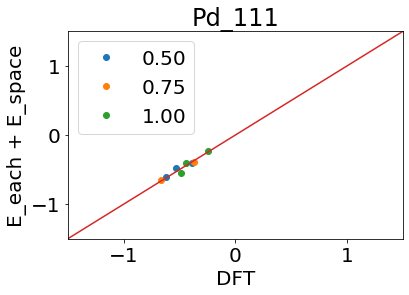

In [10]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20

for i in range(len(dataset)):
    ax = fig.add_subplot(5, 4, i+1)
    xmin = 100
    xmax = -100
    weight2, weight3 = dataset[i].fit_weight_from_specific_element()

    for j in range(len(covset[i])):
        dfpred = dataset[i].dfpred[dataset[i].dfpred['coverage'] == covset[i][j]]
        
        E_residue_pred = dfpred['ads_dist2'] * weight2 + dfpred['ads_dist3'] * weight3
        E_ads_pred = (dfpred['E_int_space'] + dfpred['sumE_each_ads'])/dfpred['surfatomnum'] + E_residue_pred

        aveadsE_suratom = dfpred['aveadsE/suratom']
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_ads_pred, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_each + E_space')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
# plt.savefig('')
# plt.show()

In [27]:
for i in range(3):
    print(i)

0
1
2
